# Задача
1. - С помощью файла circle_generator.ipynb сгенерировать 
изображения кружочков и натренировать нейронную сеть с архитектурой UNet 
на предмет сегментации кружочков на сгенерированных изображениях.
2. - При решении выполнить разбиение датасета на train/test/validation
3. - Рассчитать значение функции потерь и метрики на трейне и тесте во время обучения
4. - Построить график функции потерь на трейне и тесте по результатам обучения
5. - Оценить качество модели на валидации на выбранной метрике.

# Решение

## 1. Подготовка данных

Импорт необходимых библиотек

In [1]:
import os
import re
from skimage.transform import resize
from skimage.color import rgb2gray
import torch
import torch.cuda
from torchvision import transforms
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Укажем пути хранения изображений кружков и соответствующим им масок, которые были сгенерированы с помощью файла circles_generator.ipynb в формате .png, для обучающей и тестовой выборок.

In [2]:
train_images_dir = 'data/train_png/imgs'
train_masks_dir = 'data/train_png/masks'

test_images_dir = 'data/test_png/imgs'
test_masks_dir = 'data/test_png/masks'

Зададим входные и выходные размеры изображений/масок

In [3]:
image_size = 256
input_image_size = (572, 572)

Подготовим списки изображений и масок, применяемых для обучения модели, и укажем их количество

In [4]:
train_images_listdir = os.listdir(train_images_dir)
train_masks_listdir = os.listdir(train_masks_dir)

print(f"Dataset contains {len(train_images_listdir)} images")
print(f"Dataset contains {len(train_masks_listdir)} masks")

Dataset contains 1500 images
Dataset contains 1500 masks


Создадим функцию для считывания изображений (изображений кружков и масок). Визуализируем несколько случайно отобранных изображений и масок

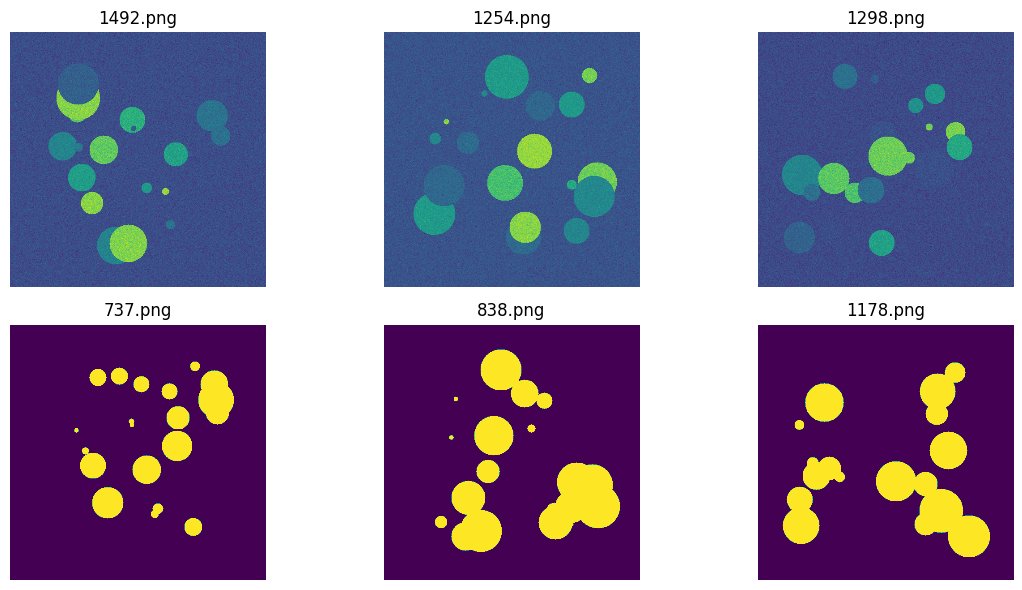

In [5]:
def read_image(path):

    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (image_size, image_size))
    return img

random_images = np.random.choice(train_images_listdir, size = 3, replace = False)
random_masks = np.random.choice(train_masks_listdir, size = 3, replace = False)
rows = 2
cols = 3
fig, ax = plt.subplots(rows, cols, figsize = (12,6))

for i, ax_i in enumerate(ax.flat):
    if i < 3:
        img = read_image(f"{train_images_dir}/{random_images[i]}")
        ax_i.imshow(img)
        ax_i.set_title(f"{random_images[i]}")
    else:
        mask_index = i - 3        
        mask = read_image(f"{train_masks_dir}/{random_masks[mask_index]}")
        mask = (rgb2gray(mask) * 255).astype(np.uint8)
            
        ax_i.imshow(mask)
        ax_i.set_title(f"{random_masks[mask_index]}")
    ax_i.axis('off')

plt.tight_layout()
plt.show()

Для последующего создания датасета требуется список файлов, образующих обучающую и тестовую выборки. Прежде чем получить такой словарь создадим функцию для извлечения номера из названия файла изображений/масок для обучающей и тестовой выборок.

In [6]:
def extract_number(filename):
    # Используем регулярное выражение для извлечения числа
    match = re.search(r'\d+', filename)
    return int(match.group()) if match else 0

# Сортировка с использованием числового ключа
sorted_train_images = sorted(train_images_listdir, key=extract_number)
sorted_train_masks = sorted(train_masks_listdir, key=extract_number)

print(sorted_train_images)

['0.png', '1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png', '10.png', '11.png', '12.png', '13.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png', '40.png', '41.png', '42.png', '43.png', '44.png', '45.png', '46.png', '47.png', '48.png', '49.png', '50.png', '51.png', '52.png', '53.png', '54.png', '55.png', '56.png', '57.png', '58.png', '59.png', '60.png', '61.png', '62.png', '63.png', '64.png', '65.png', '66.png', '67.png', '68.png', '69.png', '70.png', '71.png', '72.png', '73.png', '74.png', '75.png', '76.png', '77.png', '78.png', '79.png', '80.png', '81.png', '82.png', '83.png', '84.png', '85.png', '86.png', '87.png', '88.png', '89.png', '90.png', '91.png', '92.png', '93.png', '94.png', '95.png', '96.png', '97.png', '98.png', '99.png', '100.png'

Создадим функцию загрузки данных. Она генерирует нулевые массивы, размер которых соответствует длине списка обучающих изображений и масок. Поскольку изображения цветные, они имеют 3 канала; маски имеют один канал. После генерации нулевых массивов они заполняются данными, полученными при считывании изображений. В случае масок изображение преобразуется в черно-белое; чтобы получить значения цвета в диапазоне от 0 до 255, а не от 0 до 1, умножаем на 255, после чего преобразуем булевые значения в целые числа. Затем для маски добавляется новая ось для обеспечения соответствия размеров.

In [8]:
def load_data(image_list, mask_list):
    images = np.zeros((len(image_list), image_size, image_size, 3), dtype=np.uint8)
    masks = np.zeros((len(mask_list), image_size, image_size, 1), dtype=np.uint8)
    
    for i, (img_name, mask_name) in enumerate(zip(image_list, mask_list)):
        images[i] = read_image(f"{train_images_dir}/{img_name}")
        mask = read_image(f"{train_masks_dir}/{mask_name}")
        mask = (rgb2gray(mask) * 255).astype(np.uint8)
        masks[i] = mask[..., np.newaxis]
    
    return images, masks

train_images, train_masks = load_data(sorted_train_images, sorted_train_masks)
print(f"Размер матрицы обучающего набора изображений: {train_images.shape}")
print(f"Размер матрицы обучающего набора масок: {train_masks.shape}")
print(f"Уникальные оттенки цвета в маске: {np.unique(train_masks)}")

Размер матрицы обучающего набора изображений: (1500, 256, 256, 3)
Размер матрицы обучающего набора масок: (1500, 256, 256, 1)
Уникальные оттенки цвета в маске: [ 21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182
 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200
 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218
 219 220 221]


Сформировав матрицы для обучающих данных, разобьем их на обучающую и валидационную выборки (20 % от выборки). В итоге, обучающая выборка содержит 1200 изображений и соответствующих масок, а валидационная выборка - 300 изображений и соответствующих масок.

In [9]:
images_train, images_valid, masks_train, masks_valid = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)

print(f"Training set shapes\nImages : {images_train.shape}\nMasks : {masks_train.shape}")
print(f"Validating set shapes \nImages : {images_valid.shape}\nMasks : {masks_valid.shape}")

Training set shapes
Images : (1200, 256, 256, 3)
Masks : (1200, 256, 256, 1)
Validating set shapes 
Images : (300, 256, 256, 3)
Masks : (300, 256, 256, 1)


Создадим датасет для обучения модели сегментации изображений. В данной задаче для обучения будет применяться модель resnet34, которая требует нормирования данных по соответствующим каналам цветного изображения (экспериментально найденная нормировка по результатам обучения на датасете Imagenet). В случае масок, хотя должно быть 2 класса (фон и сама маска), может наблюдаться большее количество классов (цветов), как это наблюдалось выше, где выведены уникальные оттенки цвета, присутствующие в маске. Это обусловлено особенностями формирования изображения, пограничными эффектами и т.д. Поэтому необходимо распределить все возможные оттенки цветов по 2 классам. Границей разделения будет значение 121 как середина диапазона уникальных значений от 21 до 221.

In [10]:
class SegmentationDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

        # Трансформации для изображений (нормализация)
        self.transforms_imgs = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        mask = (mask > 121).astype(np.uint8)

        return self.transforms_imgs(image), torch.from_numpy(mask).long().squeeze()

На основе созданного датасета сгенерируем DataLoader, который будет подавать обучающие данные сериями по 4 изображения с перемешиванием. Для валидационного датасета перемешивание не проводим.

In [11]:
train_ds = SegmentationDataset(images_train, masks_train)
val_ds = SegmentationDataset(images_valid, masks_valid)

train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=False)

## 2. Обучение модели

Для решения данной задачи сегментации используем модель Unet из библиотеки segmentation_models_pytorch. В качестве backbone модели в ней применяется resnet34. Количество входных каналов = 3 (цветное изображение), количество классов = 2 (фон и маска).

In [12]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=2,
).to(device)

print(model)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

Как видно выше на изображениях и масках, соотношение фона и кружков разное, т.е. классы несбалансированы. Во избежание преимущественного обучения моделью обнаружения фона в ущерб кружков, определим соотношение фона и кружков на обучающем наборе масок. В итоге получаем соотношение 1:5,77.

In [15]:
def calculate_class_weights(masks):
    masks = (masks > 121).astype(np.uint8)
    class_counts = np.bincount(masks.flatten())
    return torch.tensor([1.0, class_counts[0]/class_counts[1]]).float().to(device)

In [16]:
class_weights = calculate_class_weights(train_masks)
print("Class weights:", class_weights)

Class weights: tensor([1.0000, 5.7658], device='cuda:0')


Зададим функцию потерь unet_loss. В ее основе лежит кросс-энтропийная функция потерь с использованием весов для классов (веса найдены выше). Кроме того, функция unet_loss рассчитывает правильность отнесения пикселей к классу.

In [17]:
ce = nn.CrossEntropyLoss(weight=class_weights).to(device)

def unet_loss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc

Зададим функции обучения модели на обучающей и валидационной выборках. 

In [18]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, ce_masks = data
    ims = ims.to(device)
    ce_masks = ce_masks.to(device)
    _masks = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    ims = ims.to(device)
    masks = masks.to(device)
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

Зададим функции потерь и оптимизатор AdamW (скорость обучения = 1e-4). Зададим количество эпох.

In [19]:
from torch import optim

criterion = unet_loss
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
n_epochs = 5

Создадим класс для логирования данных на каждом шаге. На основе зарегистрированных данных строим график изменения метрик по эпохам.

In [20]:
class Report:
    def __init__(self, n_epochs):
        self.n_epochs = n_epochs
        self.metrics = {'trn_loss': [], 'val_loss': [],
                        'trn_acc': [], 'val_acc': []}
        self.steps = {key: [] for key in self.metrics}

    def record(self, pos, **kwargs):
        for key, value in kwargs.items():
            if key in self.metrics:
                self.metrics[key].append(value)
                self.steps[key].append(pos)

    def plot_epochs(self, metrics):
        for metric in metrics:
            plt.plot(self.steps[metric], self.metrics[metric], label=metric)
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.legend()
        plt.show()

Проведем обучение модели на обучающей выборке с контролем метрик на валидационной выборке.

In [21]:
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(train_dl)
    for bx, data in enumerate(train_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex + (bx + 1) / N, trn_loss=loss, trn_acc=acc)
        print(f'Train Epoch [{ex+1}/{n_epochs}] '
              f'Batch [{bx+1}/{N}] '
              f'train_loss: {loss:.4f}, train_acc: {acc:.4f}')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex + (bx + 1) / N, val_loss=loss, val_acc=acc)
        print(f'Val Epoch [{ex+1}/{n_epochs}] '
              f'Batch [{bx+1}/{N}] '
              f'val_loss: {loss:.4f}, val_acc: {acc:.4f}')

    print()

Train Epoch [1/5] Batch [1/300] train_loss: 0.8134, train_acc: 0.7245
Train Epoch [1/5] Batch [2/300] train_loss: 0.6988, train_acc: 0.7603
Train Epoch [1/5] Batch [3/300] train_loss: 0.6495, train_acc: 0.7857
Train Epoch [1/5] Batch [4/300] train_loss: 0.6098, train_acc: 0.7990
Train Epoch [1/5] Batch [5/300] train_loss: 0.5606, train_acc: 0.8235
Train Epoch [1/5] Batch [6/300] train_loss: 0.5208, train_acc: 0.8427
Train Epoch [1/5] Batch [7/300] train_loss: 0.4962, train_acc: 0.8543
Train Epoch [1/5] Batch [8/300] train_loss: 0.4569, train_acc: 0.8743
Train Epoch [1/5] Batch [9/300] train_loss: 0.4627, train_acc: 0.8688
Train Epoch [1/5] Batch [10/300] train_loss: 0.4081, train_acc: 0.8879
Train Epoch [1/5] Batch [11/300] train_loss: 0.4205, train_acc: 0.8859
Train Epoch [1/5] Batch [12/300] train_loss: 0.4013, train_acc: 0.8865
Train Epoch [1/5] Batch [13/300] train_loss: 0.4116, train_acc: 0.8928
Train Epoch [1/5] Batch [14/300] train_loss: 0.3760, train_acc: 0.9078
Train Epoch [1/

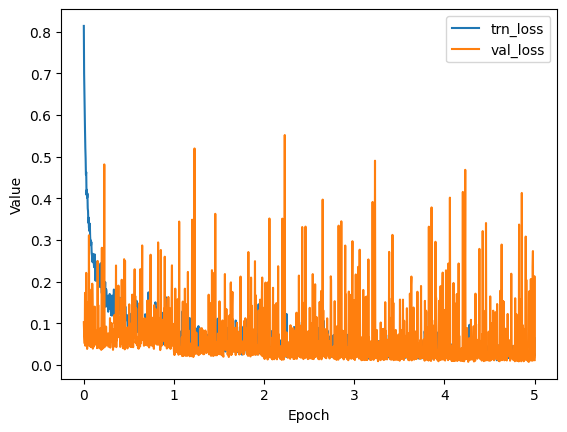

In [22]:
log.plot_epochs(['trn_loss','val_loss'])

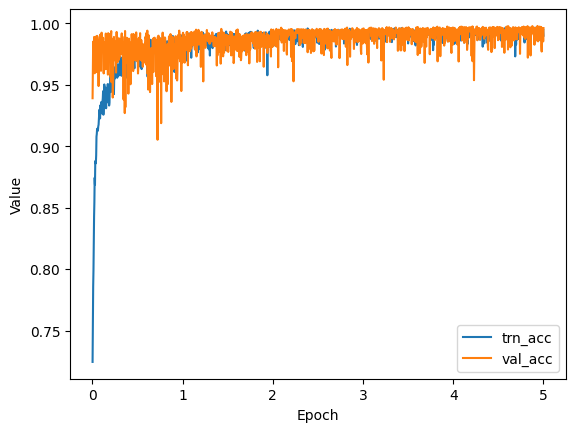

In [23]:
log.plot_epochs(['trn_acc','val_acc'])

Модель демонстрирует обучение, достигая значений 0,99 для accuracy. Для валидационных данных отмечается заметный разброс значений функции потерь.

## 3. Оценка качества модели на тестовых данных

Выполним оценку качества обучения модели на тестовых данных. Для этого создадим функцию, которая преобразует изображения аналогично тому, как это выполнялось для обучающей выборки.

Подготовим функции для обработки тестовых изображений кружков (считывание, преобразование в тензор, добавление оси для подачи в батчах), тестовых масок (считывание, преобразование цветовой карты в черно-белую, разбиение по классам), функцию сегментации подготовленного на предыдущем этапе изображения и оценки наиболее вероятного класса с помощью softmax, функцию расчета значений IoU для каждого класса.

In [25]:
# Преобразования
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def preprocess_image(image_path):
    image = read_image(image_path)
    image = image_transform(image)
    image = image.unsqueeze(0)
    return image.to(device)

def preprocess_mask(mask_path):
    mask = read_image(mask_path)
    mask = (rgb2gray(mask) * 255).astype(np.uint8)
    mask = (mask > 121).astype(np.uint8)
    return mask

def segment_image(model, image_path):
    model.eval()
    with torch.no_grad():
        input_tensor = preprocess_image(image_path)
        output = model(input_tensor)
        output = torch.softmax(output, dim=1)
        pred_mask = output.squeeze(0).cpu().argmax(dim=0).numpy()
    return pred_mask

def compute_iou_per_class(pred_mask, true_mask, num_classes):
    ious = []
    for cls in range(num_classes):
        pred_cls = (pred_mask == cls)
        true_cls = (true_mask == cls)
        intersection = np.logical_and(pred_cls, true_cls).sum()
        union = np.logical_or(pred_cls, true_cls).sum()
        ious.append(intersection / union if union > 0 else np.nan)
    return ious

def visualize_prediction(image_path, true_mask, pred_mask):
    original_image = Image.open(image_path)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask)
    plt.title('True Mask')
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask)
    plt.title('Predicted Segmentation')
    plt.show()

Подготовим функцию оценки модели, которая использует подготовленные ранее функции для генерации предсказания маски и оригинального изображения и маски, а также рассчитывает точность сегментации и визуализирует первых 5 изображений, истинных и предсказанных масок.

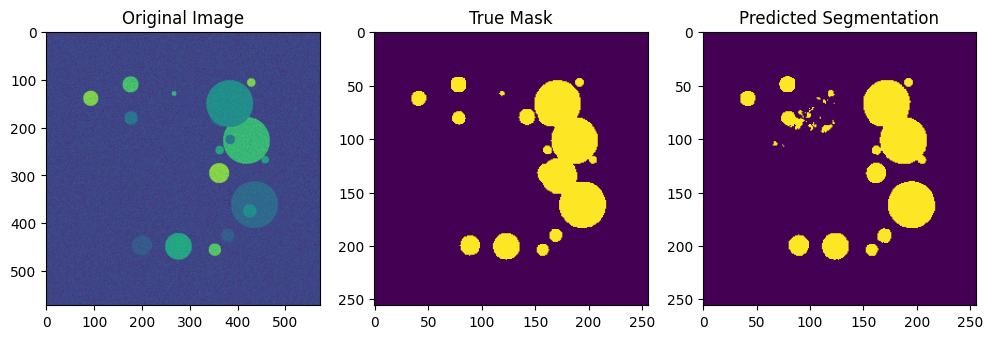

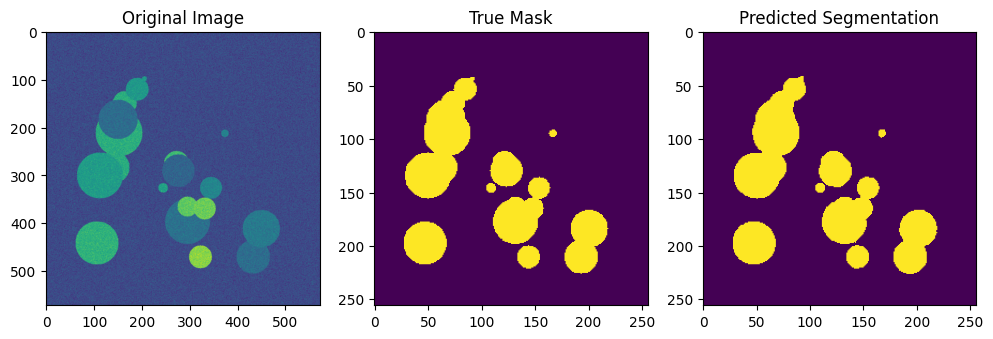

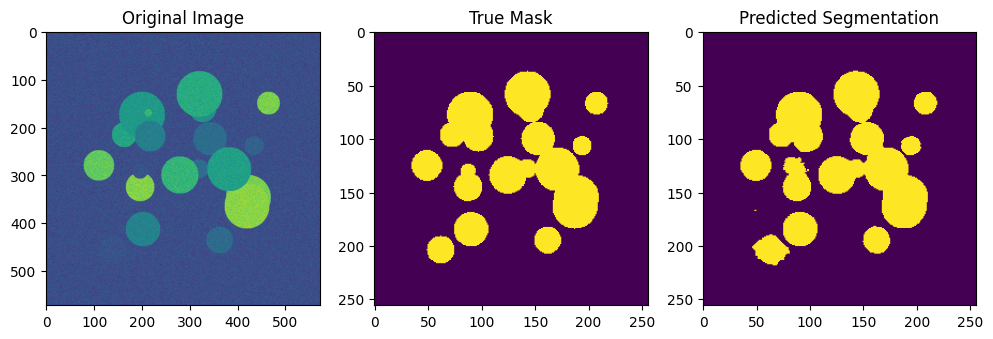

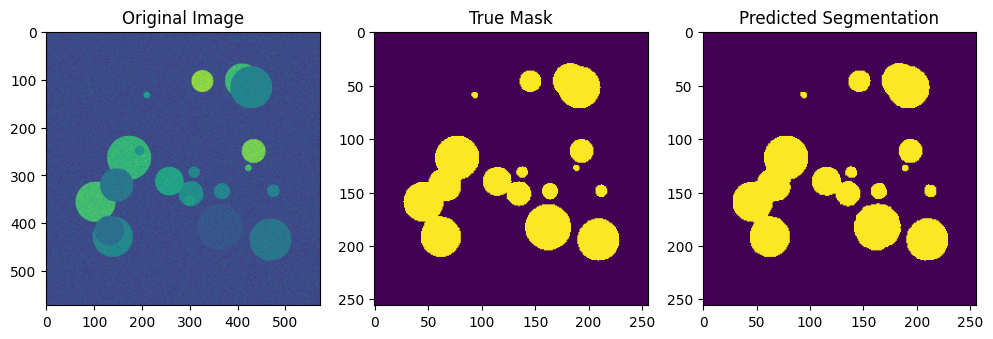

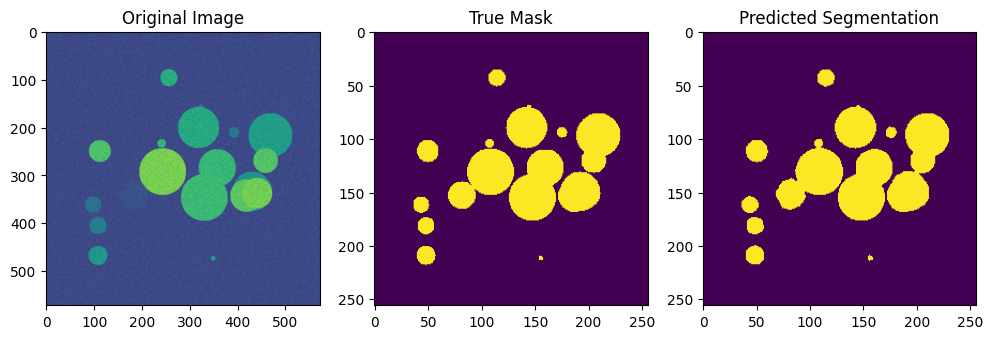

Pixel Accuracy: 0.9930
IoU for class 0: 0.9918
IoU for class 1: 0.9532
Mean IoU: 0.9725


In [26]:
def evaluate_model(model, visualize_indices=range(0, 5)):
    image_filenames = [f for f in os.listdir(test_images_dir) if f.endswith(('.png', '.jpg'))]

    total_pixels = 0
    correct_pixels = 0
    iou_list = []

    for idx, fname in enumerate(image_filenames):
        image_path = os.path.join(test_images_dir, fname)
        mask_path = os.path.join(test_masks_dir, fname)

        pred_mask = segment_image(model, image_path)
        true_mask = preprocess_mask(mask_path)

        correct_pixels += (pred_mask == true_mask).sum()
        total_pixels += pred_mask.size

        ious = compute_iou_per_class(pred_mask, true_mask, num_classes=2)
        iou_list.append(ious)

        if idx in visualize_indices:
            visualize_prediction(image_path, true_mask, pred_mask)

    pixel_accuracy = correct_pixels / total_pixels
    iou_array = np.array(iou_list)
    mean_iou_per_class = np.nanmean(iou_array, axis=0)
    mean_iou = np.nanmean(mean_iou_per_class)

    print(f"Pixel Accuracy: {pixel_accuracy:.4f}")
    for i, iou in enumerate(mean_iou_per_class):
        print(f"IoU for class {i}: {iou:.4f}")
    print(f"Mean IoU: {mean_iou:.4f}")

evaluate_model(model)

Наблюдаются очень высокие показатели качества сегментирования. Значения IoU для класса 0 (фон) чуть выше, чем для класса 1 (кружки), что и должно было наблюдаться, поскольку класс 0 (фон) детектируется проще.

## Заключение

Удалось добиться высокого качества сегментации изображений как из обучающей, так и из тестовой выборки. Модель resnet34 демонстрирует отличные показатели качества. В ходе подготовки решения были изучены изображения в формате .jpg. Вследствие сжатия данных при генерации изображений в формате .jpg наблюдались более низкие показатели качества.